# implied counts

Adjust counts for time lags and unconfirmed cases.

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 0

import etl
from pandas import DataFrame

FIGSIZE = (9, 5)

Autosave disabled


## realized counts

Load examples from [CoronaWatchNL] via jonathandebruinos@gmail.com.

[CoronaWatchNL]: https://github.com/J535D165/CoronaWatchNL

In [2]:
real = etl.rivm().loc[:'2020-03-30']
real[::5]

,confirmed,deceased,hospitalized
date,,,
2020-02-27,3,0,1
2020-03-03,40,0,6
2020-03-08,71,2,14
2020-03-13,217,6,63
2020-03-18,461,20,160
2020-03-23,619,81,302
2020-03-28,989,126,358


## implied exposures

Assumptions:

- False-positive rate P(confirmed | not exposed) = 0.
- Confirmation rate P(confirmed | exposed) = `cprob`.
- Confirmations occur `ctime` days after exposure.

**Caution:** If testing is common, then ignoring false positives leads to the [prosecutor's fallacy].

[prosecutor's fallacy]: https://en.wikipedia.org/wiki/Prosecutor's_fallacy

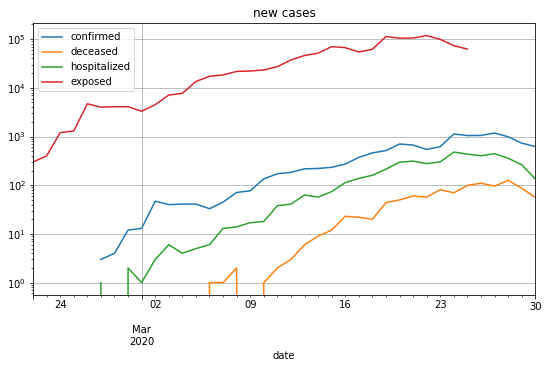

In [3]:
cprob = 0.01
ctime = 5

exposed = (
    real['confirmed'].rename('exposed')
    .div(cprob).shift(-ctime, freq=real.index.freq)
)
data = real.join(exposed, how='outer')
axes = data.plot(figsize=FIGSIZE, grid=True, logy=True, title='new cases')

## implied fatality rates

Assumptions:

- Unconfirmed cases are never fatal.
- Deaths occur `dtime` days after exposure.

**Caution:** P(deceased | exposed) may be much less than [case fatality rate].

[case fatality rate]: https://en.wikipedia.org/wiki/Case_fatality_rate

0.227 deaths per confirmed case
0.006 deaths per implied exposure


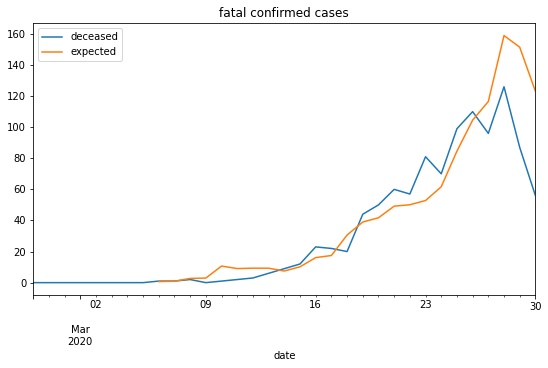

In [4]:
dtime = ctime + 8

confirmed = real['confirmed']
deceased = real['deceased']

cfr = deceased.sum() / confirmed.iloc[: -(1 + dtime - ctime)].sum()
ifr = deceased.sum() / exposed.iloc[: -(1 + dtime)].sum()
print(f"{cfr.round(3)} deaths per confirmed case")
print(f"{ifr.round(3)} deaths per implied exposure")

data = DataFrame(real['deceased'])
data['expected'] = cfr * real['confirmed'].shift(dtime - ctime)
axes = data.plot(figsize=FIGSIZE, title='fatal confirmed cases')